#Notebook comparing system behavior using Finite-Horizon LQR and Infinite-Horizon LQR

In [ ]:
pip install control

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.1/455.1 kB 8.2 MB/s eta 0:00:00


In [ ]:
import control
import numpy as np

A = np.array([ [1.0,  0.5],
                [  0, 1.0]])

B = np.array([[0], [0.5]])

R = 0.1

Q = np.array([[1.0, 0],
              [0, 1.0]])

PN = Q

N = 10

In [ ]:
# Calculate Finite-Horizon LQR gain
# only depends on problem data, not initial state

P = [None] * (N + 1)
P[N] = PN

F = [None] * N
for i in range(N, 0, -1):
    P[i-1] = Q + A.T @ P[i] @ A - (A.T @ P[i] @ B) @ np.linalg.pinv(R + B.T @ P[i] @ B) @ (B.T @ P[i] @ A)
    F[i-1] = np.linalg.pinv(R + B.T @ P[i] @ B) @ B.T @ P[i] @ A


In [ ]:
print(P)

[array([[4.57047845, 3.0814892 ],
       [3.0814892 , 5.50485108]]), array([[4.56824896, 3.07894472],
       [3.07894472, 5.5010832 ]]), array([[4.56276799, 3.0722999 ],
       [3.0722999 , 5.49104687]]), array([[4.54851405, 3.05440829],
       [3.05440829, 5.46431374]]), array([[4.51082758, 3.00687444],
       [3.00687444, 5.39537231]]), array([[4.41413711, 2.88721672],
       [2.88721672, 5.22831004]]), array([[4.18558443, 2.61474732],
       [2.61474732, 4.86243741]]), array([[3.71955082, 2.08997984],
       [2.08997984, 4.18031961]]), array([[2.95867769, 1.30991736],
       [1.30991736, 3.17561983]]), array([[2.  , 0.5 ],
       [0.5 , 2.05]]), array([[1., 0.],
       [0., 1.]])]


383.58510683660296
383.5851068366029


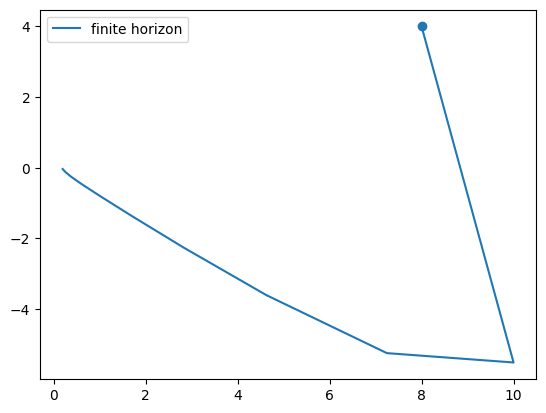

In [ ]:
# Simulate System

x0 = np.array([[8], [4]])

xreg = [None]*(N+1)
xreg[0] = x0
costreg = x0.T@Q@x0

for k in range (0,N):

  # calculate input
  ureg = -F[k]@xreg[k]

  # apply input to system
  xreg[k+1] = A@xreg[k] + B@ureg

  # calculate and add stage cost
  costreg += xreg[k+1].T@Q@xreg[k+1] + R*ureg**2

xreg = np.squeeze(xreg)

# plot
import matplotlib.pyplot as plt
plt.scatter(xreg[0,0], xreg[0,1])
plt.plot(np.asarray(xreg)[:,0], np.asarray(xreg)[:,1],label='finite horizon')
plt.legend()

# compare cost
print(xreg[0]@P[0]@xreg[0].T)
print(np.squeeze(costreg))


In [ ]:
# Calculate Infinite-Horizon LQR gain u = Finf*x

# check controllability of A, B, Q, R
C = control.ctrb(A, B)
print(np.linalg.matrix_rank(C) == 2)

# check observatibility of blah
O = control.obsv(A, Q)
print(np.linalg.matrix_rank(O) == 2)

Finf, Jinf, Einf = control.dlqr(A, B, Q, R)

print(Finf)

# eigenvalues of closed-loop system
print(Einf)

True
True
[[1.22142483 2.31233669]]
[0.5916954 +0.j 0.25213625+0.j]


[[383.58510684]]
[[383.60261114]]
[[383.61738629]]


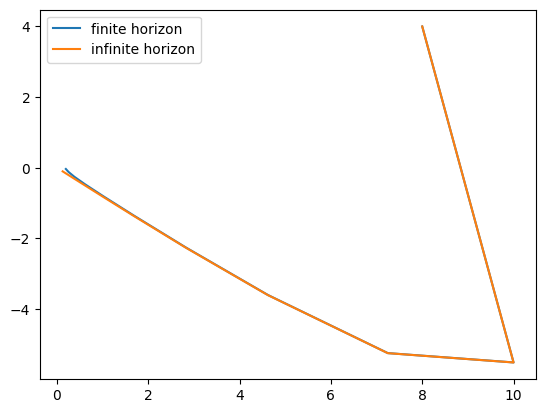

In [ ]:
# Comparison with infinite horizon LQR

xinf = [None]*(N+1)
xinf[0] = x0
costinf = x0.T@Q@x0

for k in range (0,N):
  uinf = -Finf@xinf[k]
  xinf[k+1] = A@xinf[k] + B@uinf
  costinf += xinf[k+1].T@Q@xinf[k+1] + R*(uinf**2)

plt.plot(np.asarray(xreg)[:,0], np.asarray(xreg)[:,1],label='finite horizon')
plt.plot(np.asarray(xinf)[:,0], np.asarray(xinf)[:,1],label = 'infinite horizon')
plt.legend()

print(costreg)
print(costinf)
print(x0.T@Jinf@x0)

True
[0.5916954  0.25213625]


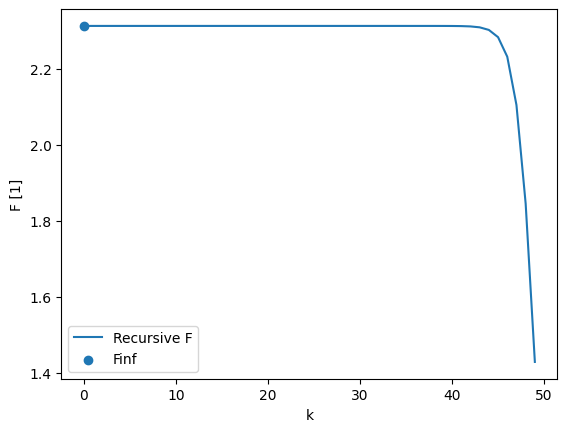

In [ ]:
# Convergence of Fk to Finf

N = 50

P = [None] * (N + 1)
P[N] = PN

# check controllability of A, B, Q, R
C = control.ctrb(A, B)
print(np.linalg.matrix_rank(C) == 2)

F = [None] * N
for i in range(N, 0, -1):
    P[i-1] = Q + A.T @ P[i] @ A - (A.T @ P[i] @ B) @ np.linalg.pinv(R + B.T @ P[i] @ B) @ (B.T @ P[i] @ A)
    F[i-1] = np.linalg.pinv(R + B.T @ P[i] @ B) @ B.T @ P[i] @ A
F = np.squeeze(F)

closed_loop = np.matmul(B, np.reshape(F[0],(1,2)))
eigenvals, eigenvecs = np.linalg.eig(A - closed_loop)
print(eigenvals)

#Finf, Jinf, Einf = control.dlqr(A, B, Q, R)
plt.plot(F[:,1], label='Recursive F')
plt.scatter(0, Finf[0][1],label='Finf')
plt.xlabel('k')
plt.ylabel('F [1]')
plt.legend()

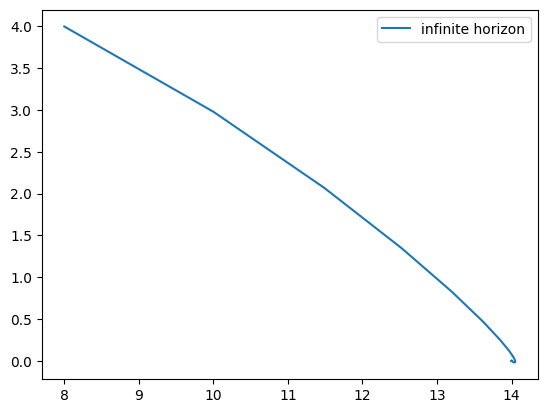

In [ ]:
# Different reference

N = 50

xref = np.array([[14], [0]])

xinf = [None]*(N+1)
xinf[0] = x0

for k in range (0,50):
  uinf = -Finf@(xinf[k] - xref)
  xinf[k+1] = A@xinf[k] + B@uinf
  costinf += xinf[k+1].T@Q@xinf[k+1] + R*(uinf**2)

plt.plot(np.asarray(xinf)[:,0], np.asarray(xinf)[:,1],label = 'infinite horizon')
plt.legend()